In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('./owid-covid-data.xlsx')

In [3]:
Europe = df[df['iso_code']=='OWID_EUR']
Europe = Europe.fillna(0)

date = pd.DataFrame({'일자' : Europe['date']})
location = pd.DataFrame({'location' : Europe['location']})

Europe.drop(['iso_code','continent','location','date'], axis=1,inplace=True)

In [4]:
X = Europe[['total_cases',
 'icu_patients',
 'total_vaccinations',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate',
'new_tests',
'total_tests']]
y = Europe['new_deaths']

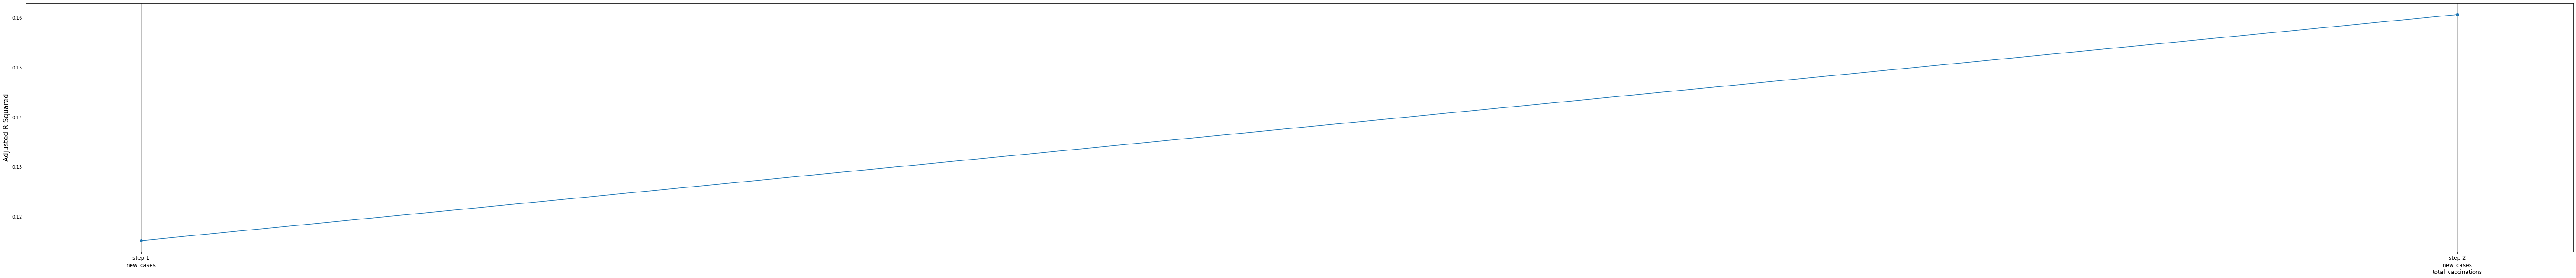

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [6]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     64.93
Date:                Wed, 11 May 2022   Prob (F-statistic):           1.73e-26
Time:                        20:35:50   Log-Likelihood:                -5838.6
No. Observations:                 669   AIC:                         1.168e+04
Df Residuals:                     666   BIC:                         1.170e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1940.3497     76

In [7]:
X = Europe[selected_variables]
X

,new_cases,total_vaccinations
53674,0.0,0.000000e+00
53675,2.0,0.000000e+00
53676,1.0,0.000000e+00
53677,0.0,0.000000e+00
53678,1.0,0.000000e+00
...,...,...
54506,257821.0,1.274093e+09
54507,282862.0,1.274321e+09
54508,214321.0,1.274498e+09
54509,123731.0,1.274532e+09


In [8]:
lm = sm.OLS(y, X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             new_deaths   R-squared (uncentered):                   0.411
Model:                            OLS   Adj. R-squared (uncentered):              0.410
Method:                 Least Squares   F-statistic:                              291.6
Date:                Wed, 11 May 2022   Prob (F-statistic):                    8.76e-97
Time:                        20:35:51   Log-Likelihood:                         -7584.6
No. Observations:                 837   AIC:                                  1.517e+04
Df Residuals:                     835   BIC:                                  1.518e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
new_cases              0.0037      0.000     12.207      0.000       0.003       0.004
total_vaccinations  5.336e-07   1.92e-07      2.780      0.006    1.57e-07     9.1e-07
==============================================================================
Omnibus:                       19.245   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.606
Skew:                           0.334   Prob(JB):                     3.35e-05
Kurtosis:                       3.381   Cond. No.                     2.62e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
p = lm.predict(X).round(0)
p_dead = pd.DataFrame({'추정사망(명)':p})
p_dead[p_dead['추정사망(명)']<=0] = 0
dead = pd.DataFrame({'사망(명)':y})

europe_COVID = pd.concat([date,location,X,dead,p_dead], axis=1)
europe_COVID.reset_index(inplace=True)
europe_COVID.drop(['index'],axis=1,inplace=True)

europe_COVID.to_excel('./유럽.xlsx')